# DSCI 100 Group Project

## Introduction

### Background Information
PLAICraft is a project undertaken by the Pacific Laboratory for AI Research at UBC. The group aims to build an embodied AI model, mimicking human behaviour in a virtual real world setting like Minecraft. To do this, the group hosts an online Minecraft server that records player actions (e.g. keypresses, mouse movements) and audio. In this project, demographic data was collected for 196 players, as well as data for specific sessions played by the players. 

### Summary
Upon inspection, the `players` dataset, in which each observation is a unique player, contains the following variables:
- `experience`, the self-reported experience level of each player: character string (should be categorical)
- `subscribe`, whether the player subscribed to a newsletter: logical
- `hashedEmail`, a unique, untraceable identifier derived from the player's email: character string
- `played_hours`, how long they played PLAICraft, in hours: numeric 
- `gender`, their self-reported gender identity: character string
- `Age`, their self-reported age in years: numeric

Data for 196 unique players is included in this dataset.

`sessions`, in which each observation is a play session, contains:
- `hashedEmail` of the player who played the session
- `start_time` and `end_time`, timestamps for the beginning and end of the play session: character strings that should be date-times
- `original_start_time` and `original_end_time`, roughly the number of milliseconds between January 1, 1970, and the beginning/end of the play session. This is a numeric data type and is far to imprecise to be useful.

Data for 1535 play sessions is included in this dataset.

### Question
Can a player's age, played hours, average session duration, and number of sessions played predict whether they will subscribe to a game-related newsletter?

### Exploratory Data Analysis

In [1]:
#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
library(themis)
library(cowplot)

options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Basic wrangling is performed on relevant parts of the data sets. The column titles are cleaned using the `janitor` package for easier reference and start and end times are converted from unusable character strings to date-time objects using the `lubridate` package.

In [2]:
sessions_url <- "https://raw.githubusercontent.com/YoyoLiu314/group-project/refs/heads/main/sessions.csv"
players_url <- "https://raw.githubusercontent.com/YoyoLiu314/group-project/refs/heads/main/players.csv"

players <- read_csv(players_url) |>
    clean_names() 
    

sessions <- read_csv(sessions_url) |>
    clean_names() |>   
    select(-starts_with("original")) |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time))



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The date-time data type allows the duration of each session to be calculated. As well, the number of sessions played by each player is counted and recorded.

In [3]:
durations <- sessions |>
    mutate(duration = end_time - start_time) |>
    group_by(hashed_email) |>
    summarize(mean = mean(duration, na.rm = TRUE), play_time = sum(duration, na.rm = TRUE), num_sessions = n())
durations

hashed_email,mean,play_time,num_sessions
<chr>,<drtn>,<drtn>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000 mins,106 mins,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000 mins,30 mins,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000 mins,11 mins,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385 mins,418 mins,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000 mins,70 mins,2
⋮,⋮,⋮,⋮
fc0224c81384770e93ca717f32713960144bf0b52ff67639433a5c06a653a882,16.00000 mins,16 mins,1
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,80.00000 mins,80 mins,1
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15.46774 mins,4795 mins,310


Using the hashed emails as an identifier, the play session data for each player is reconciled with their demographic data. `left_join` is used in order to avoid dropping players who never played (as their hased email would not appear in the `sessions` dataset). This leaves NA values for play time and number of sessions played, which are replaced by 0s. Note that, while there is also an NA value in `age`, this cannot simply be replaced by 0. When modelling, this will be resolved by imputing it with the mean age.

In [4]:
players_joined <- left_join(players, durations) |>
    select(-hashed_email) |>
    mutate(play_time = as.numeric(play_time), mean = as.numeric(mean)) |>
    mutate(play_time = replace_na(play_time, 0), mean = replace_na(mean, 0), num_sessions = replace_na(num_sessions, 0))
players_joined

Joining with `by = join_by(hashed_email)`


experience,subscribe,played_hours,name,gender,age,mean,play_time,num_sessions
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Pro,TRUE,30.3,Morgan,Male,9,74.77778,2019,27
Veteran,TRUE,3.8,Christian,Male,17,85.00000,255,3
Veteran,FALSE,0.0,Blake,Male,17,5.00000,5,1
Amateur,TRUE,0.7,Flora,Female,21,50.00000,50,1
Regular,TRUE,0.1,Kylie,Male,21,9.00000,9,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,0.0,Bailey,Female,17,0.00000,0,0
Veteran,FALSE,0.3,Pascal,Male,22,21.00000,21,1
Amateur,FALSE,0.0,Dylan,Prefer not to say,17,5.00000,5,1


As experience levels are ordinal, we can assign numerical values for them. While this is not necessarily the most nuanced (as it assumes a linear scale for game experience), it is a reasonable way to make use of this data for predictive purposes.

In [5]:
players_numeric <- players_joined |>
    mutate(exp_num = case_when(experience == "Beginner" ~ 0, 
                               experience == "Amateur" ~ 1, 
                               experience == "Regular" ~ 2, 
                               experience == "Pro" ~ 3, 
                               experience == "Veteran" ~ 4)) |>
    select(subscribe, age, mean, play_time, exp_num, num_sessions, experience) |>
    mutate(subscribe = as_factor(subscribe), experience = as_factor(experience))
players_numeric

subscribe,age,mean,play_time,exp_num,num_sessions,experience
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
TRUE,9,74.77778,2019,3,27,Pro
TRUE,17,85.00000,255,4,3,Veteran
FALSE,17,5.00000,5,4,1,Veteran
TRUE,21,50.00000,50,1,1,Amateur
TRUE,21,9.00000,9,2,1,Regular
⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,17,0.00000,0,1,0,Amateur
FALSE,22,21.00000,21,4,1,Veteran
FALSE,17,5.00000,5,1,1,Amateur


## Preliminary Visualizations

### Justification

We deliberately chose to visualize `mean` and `num_sessions` because they offer information about play patterns. Rather than solely focusing on the total play time, we will be able to look at the players' frequency (how many times they log in to play) and their engagement per session (how long they stay when playing). Visualizing these variables highlight user patterns and may provide a better prediction of long-term interest and possibly subscription behaviour. Figs. 1 and 2 include both log and continuous scales - the log graph effectively filters out "non-players" and allows better visualization of those who played for only a short duration of time.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


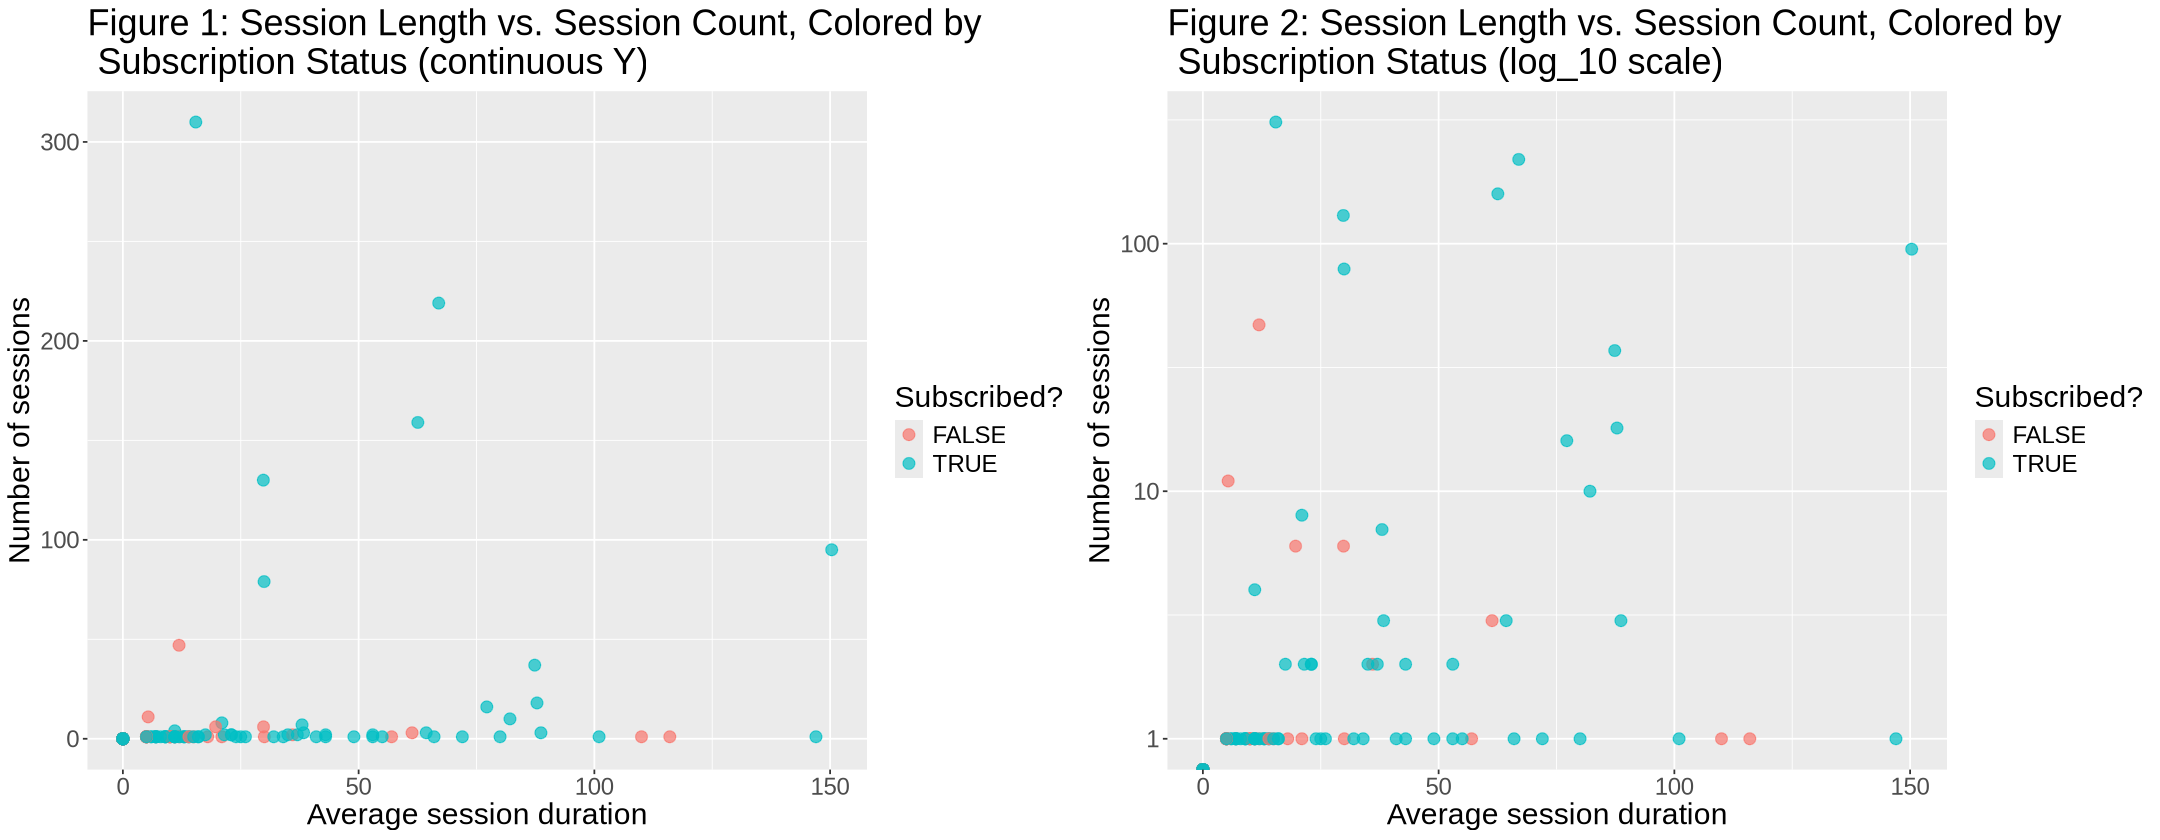

In [36]:
set.seed(1019)
# Split the data 
split <- initial_split(players_numeric, prop = 0.75)
play_train <- training(split)
play_test <- testing(split)

# Scatter plot for visualization (mean vs. num_sessions)
options(repr.plot.width = 18, repr.plot.height = 7)
length_count_plot <- ggplot(play_train, aes(x = mean, y = num_sessions, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    labs(
        title = "Figure 1: Session Length vs. Session Count, Colored by \n Subscription Status (continuous Y)",
        x = "Average session duration",
        y = "Number of sessions",
        color = "Subscribed?"
        ) +
    theme(text = element_text(size = 18))

length_count_log <- ggplot(play_train, aes(x = mean, y = num_sessions, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    labs(
        title = "Figure 2: Session Length vs. Session Count, Colored by \n Subscription Status (log_10 scale)",
        x = "Average session duration",
        y = "Number of sessions",
        color = "Subscribed?"
        ) +
     scale_y_log10() +
    theme(text = element_text(size = 18))
log_regular_plot <- plot_grid(length_count_plot, length_count_log)
   log_regular_plot


### Visual observations
Observing the scatter plot:
1. Most players are clustered near the bottom-left, indicating they play brief sessions and rarely. Many of these players are nevertheless subscribed to the newsletter.|
2. Players with high average durations or very high session counts are almost all subscribers. Indicated on the plot, the top-right region and outlier regions (long and frequent players) are mostly blue, categorizing them as subscribers.

It appears that session duration and number of sessions may be predictive of subscription - while the pattern is not strong, K-NN classification requires few assumptions about what the data must look like and thus it should be able to take advantage of any patterns in this data should they exist.

We now consider whether Minecraft experience is predictive of subscription. As K-NN classification is sensitive to bad predictors, if experience appears not to have predictive value, it will be omitted from the model.

# This one sucks, will probably delete

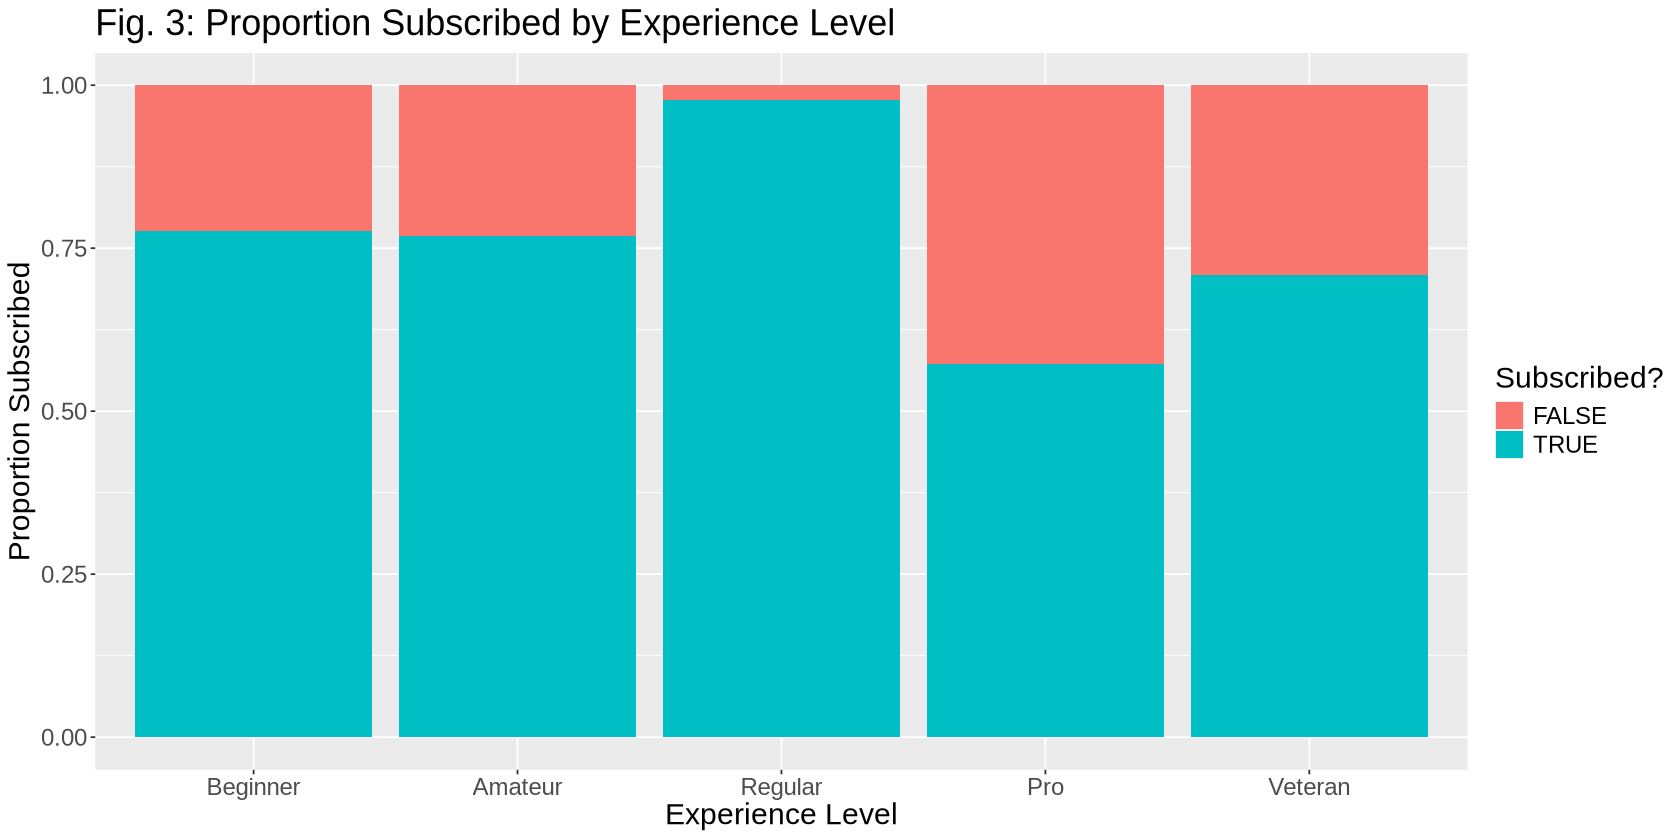

In [37]:
options(repr.plot.width = 14, repr.plot.height = 7)

play_train$experience <- factor(play_train$experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))

exp_bar <- ggplot(play_train, aes(x = experience, y = mean, fill = subscribe)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(title = "Fig. 3: Proportion Subscribed by Experience Level",
         x = "Experience Level", 
         y = "Proportion Subscribed",
        fill = "Subscribed?") +
    theme(text = element_text(size = 18))
exp_bar


Notably, "Regular" players seem to subscribe at much higher rates than other experience levels, while "Pro" players subcribe at a lower rate. This indicates that experience level may be correlated with subscription status, and as K-NN can make use of any patterns that may exist in the data, experience level will be used as a predictor.

Finally, we will consider age as a predictor using a histogram. This will show the age distribution of the playerbas as well as of subscribers and non-subscribers.

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


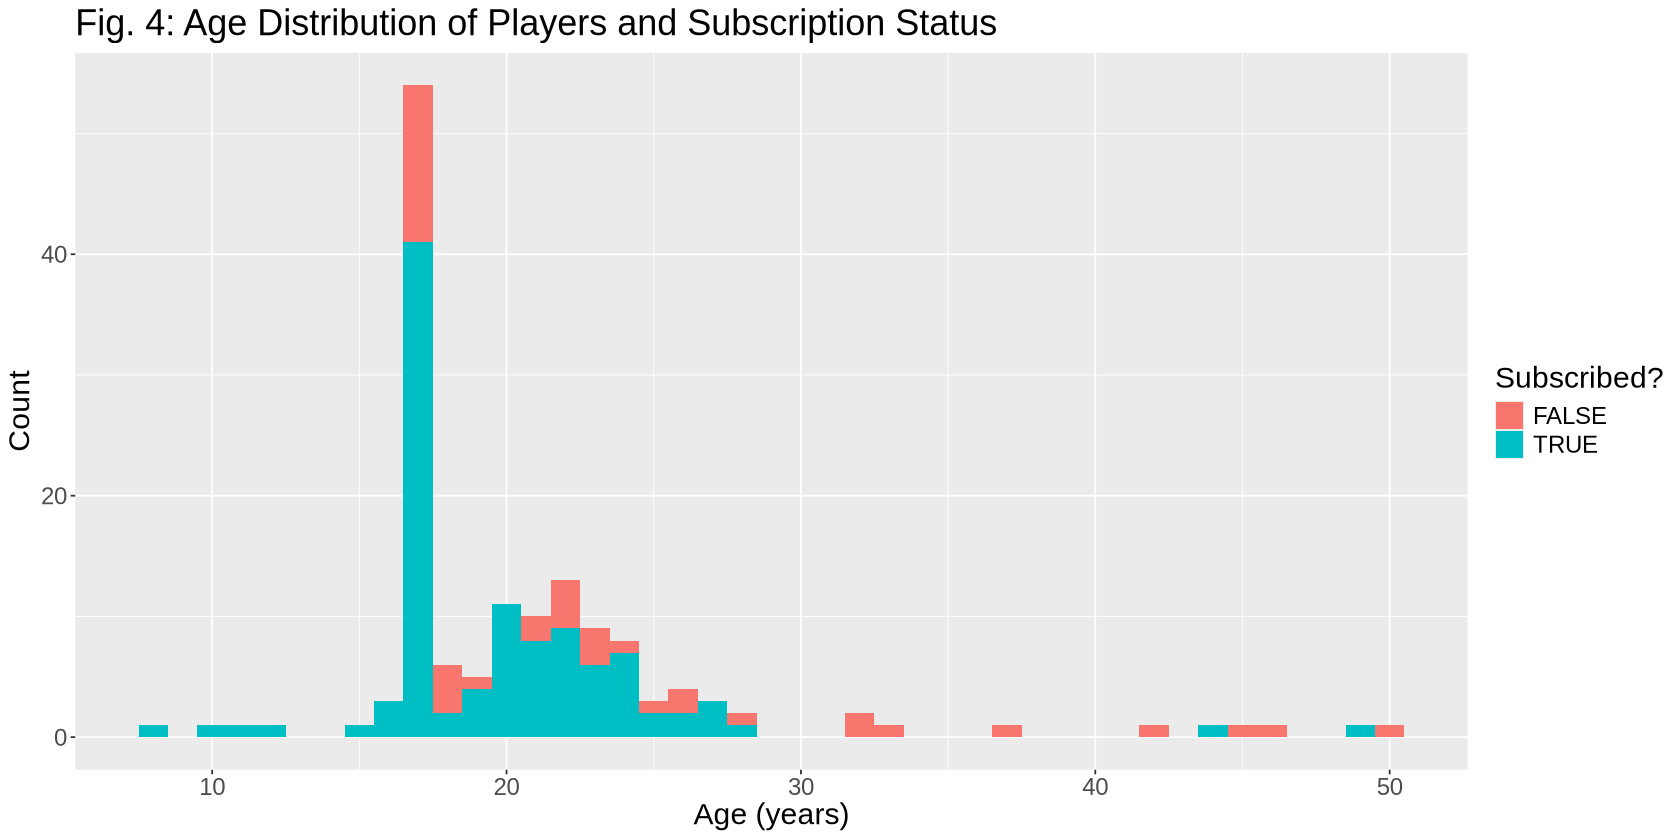

In [38]:
age_plot <- play_train |>
ggplot(aes(x = age, fill = subscribe)) +
geom_histogram(binwidth = 1) +
labs(x = "Age (years)", y = "Count", fill = "Subscribed?") +
    ggtitle("Fig. 4: Age Distribution of Players and Subscription Status") +
    theme(text = element_text(size = 18))
age_plot

Clearly, the distribution of subscribers is skewed towards younger players. Younger players are much more likely to subscribe, while only two players over 29 subscribed. However, the amount of data provided is insufficient to draw clear conclusions. As well, it is notable that there are so many 17 year old players - perhaps younger players believed 17 to be the minimum age to play, or perhaps the game was marketed to a 12th-grade class.  

## Modelling
K-NN classification with 10-fold cross-validation was used to predict subscription status in this data set. The class imbalance in the training data set was found to be about 73%/27% in favour of subscribers. This led to the model essentially predicting the majority class, TRUE, for every single observation. To resolve this, the non-subscriber class was upsampled to an equal proportion, increasing the importance of those data points and allowing the model to attempt to predict FALSE. 



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 5



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()

• Mean imputation for: all_predictors()



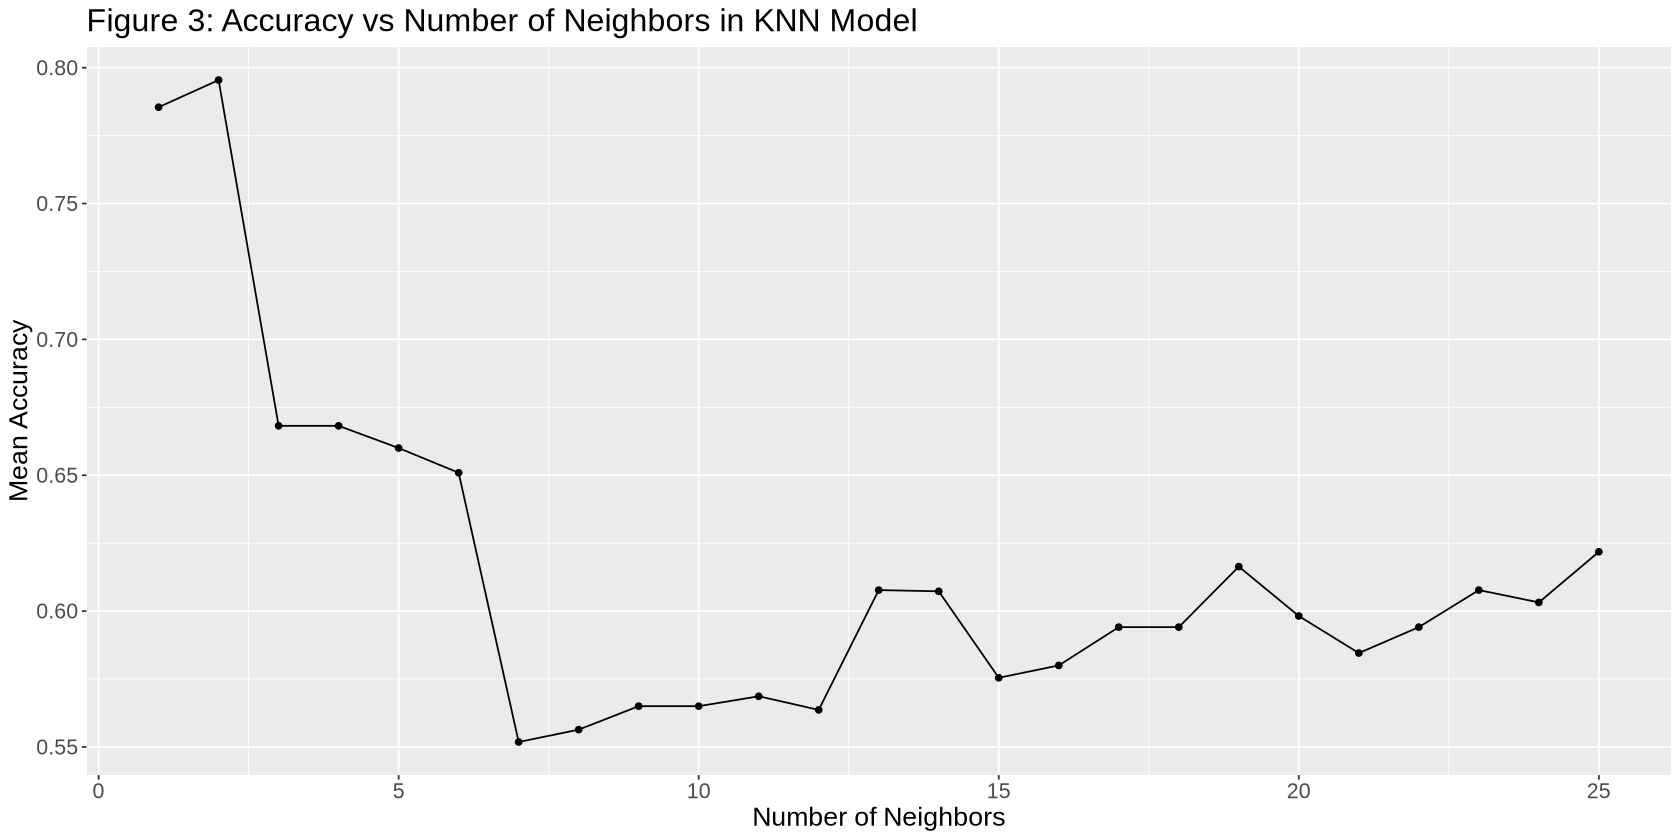

In [53]:
set.seed(1910)

train_balanced <- recipe(subscribe ~ age + mean + play_time + num_sessions + exp_num, data = play_train) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
    prep() |>
    bake(play_train)
play_recipe <- recipe(subscribe ~ age + mean + play_time + num_sessions + exp_num, data = train_balanced) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors()) 

play_recipe
k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

play_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
play_vfold <- vfold_cv(train_balanced, v = 10, strata = subscribe)

play_metrics <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(play_spec) |>
    tune_grid(resamples = play_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") 


play_plot <- play_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x= "Number of Neighbors", y="Mean Accuracy", title="Figure 3: Accuracy vs Number of Neighbors in KNN Model")+
    theme(text=element_text(size=16))

play_plot


In [40]:
best_k <- play_metrics |>
    arrange(-mean) 
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7954545,10,0.02688273,Preprocessor1_Model02
1,accuracy,binary,0.7854545,10,0.02751408,Preprocessor1_Model01
3,accuracy,binary,0.6681818,10,0.02982964,Preprocessor1_Model03
4,accuracy,binary,0.6681818,10,0.02982964,Preprocessor1_Model04
5,accuracy,binary,0.6600000,10,0.02735509,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,accuracy,binary,0.5650000,10,0.03429100,Preprocessor1_Model09
10,accuracy,binary,0.5650000,10,0.03509171,Preprocessor1_Model10
12,accuracy,binary,0.5636364,10,0.03567530,Preprocessor1_Model12


From the table above, the best k value to choose is 2. Interestingly, k = 1 and k = 2 outperform the dummy model of predicting TRUE for every single observation (which would give an accuracy of about 0.73), indicating that this model may have some predictive value. However, these low k values indicate potential overfitting. By testing the model on the testing data and making a confusion matrix, we can determine whether the model performs well on unseen data or if it is simply overfitted to the training data.

In [54]:
set.seed(1019)
final_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
      set_engine("kknn") |>
      set_mode("classification")

final_play_workflow <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(final_k_spec) 

final_play_fit <- final_play_workflow|>
    fit(data=train_balanced)


play_test_predictions <- predict(final_play_fit, new_data = play_test)|>
    bind_cols(play_test)

play_test_predictions 


.pred_class,subscribe,age,mean,play_time,exp_num,num_sessions,experience
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
TRUE,TRUE,9,74.77778,2019,3,27,Pro
TRUE,TRUE,17,85.00000,255,4,3,Veteran
TRUE,TRUE,21,50.00000,50,1,1,Amateur
FALSE,TRUE,17,13.00000,13,1,1,Amateur
TRUE,TRUE,17,0.00000,0,0,0,Beginner
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,FALSE,21,59.33333,178,4,3,Veteran
FALSE,TRUE,17,33.00000,33,1,1,Amateur
TRUE,FALSE,24,136.00000,136,1,1,Amateur


In [55]:
play_mat <- play_test_predictions |> 
      conf_mat(truth = subscribe, estimate = .pred_class)
play_mat

          Truth
Prediction FALSE TRUE
     FALSE     5    7
     TRUE      7   30

Unfortunately, the model only has 71.4% accuracy on the testing data.

## Discussion
Ultimately, the results align with our expectations. The accuracy, precision, and recall values suggest that the model performed quite well in predicting subscription status based on the available player data. Given the features—age, hours played, session count, and session duration—it makes sense that these would have a reasonable relationship with subscription behavior.

However, it's worth noting that false positives and false negatives are present, which indicates the model's ability to separate subscribers from non-subscribers is not perfect, but still quite effective.

### Impact of Findings and Potential Future Questions
The findings show that player behavior, specifically the amount of time spent playing and how often players engage with the game, can be useful in predicting whether they are likely to subscribe to a game-related newsletter. This could have significant business implications such that PLAI Craft can target advertisements to players who show certain playing behaviors like longer playing session. Additionally, by identifying factors that contribute to a subscription, developers could design features or incentives to encourage subscriptions from players who show lower engagement but could be easily changed.


This analysis could lead to several further investigations that can improve their AI model's performace. For example, what additional features (e.g., player social interaction) could further improve the model's accuracy? How does player behavior change over time, and can these changes be linked to subscription decisions or other behaviors?

### Conclusion
This analysis shows that player behavioral data—such as age, playtime, and session habits—can be predictive of their likelihood to subscribe to a newsletter. The model’s relatively high accuracy and balanced performance suggest that player data can be used effectively for targeted marketing and engagement strategies. However, further work could refine the model and explore additional factors for a more comprehensive understanding of subscription behavior.